# Define dataset and Initital Scaling

In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pylab as pl
from IPython import display


In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()

In [4]:
def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)

In [5]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}
print(Current_min, Current_max)

-0.000520787 6.74372


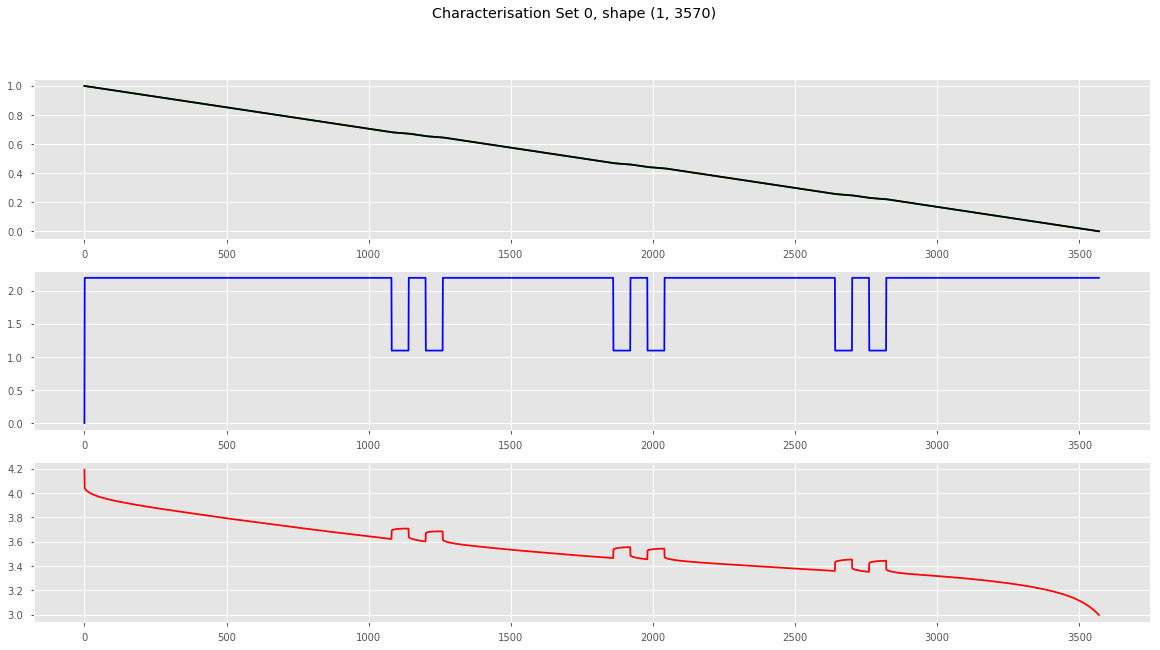

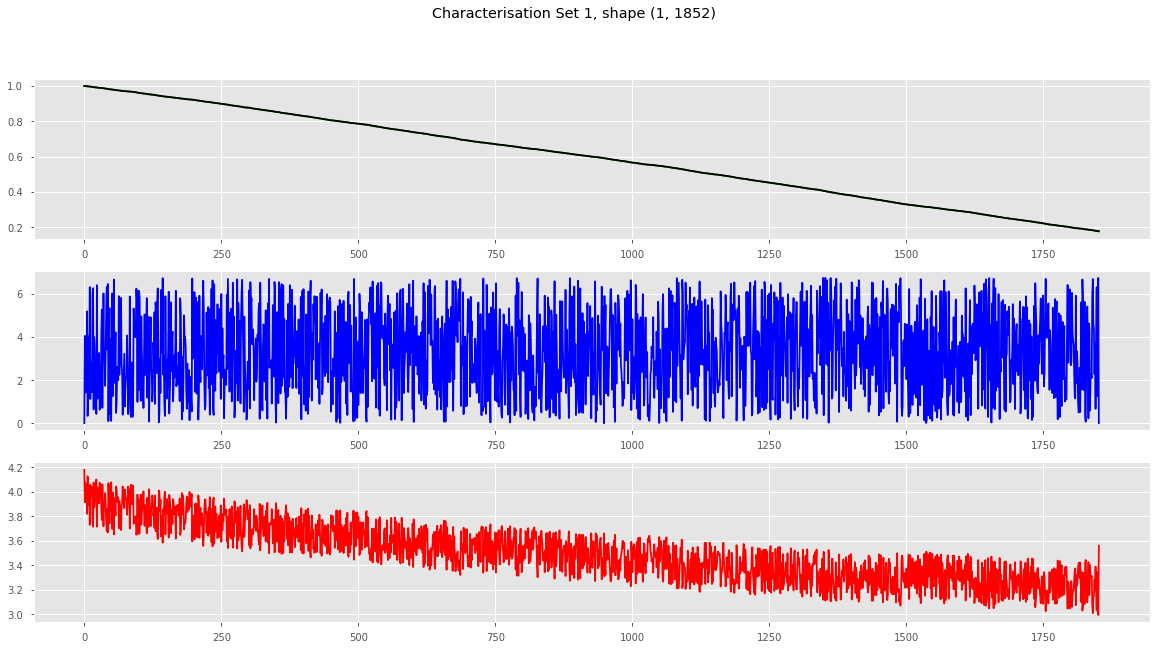

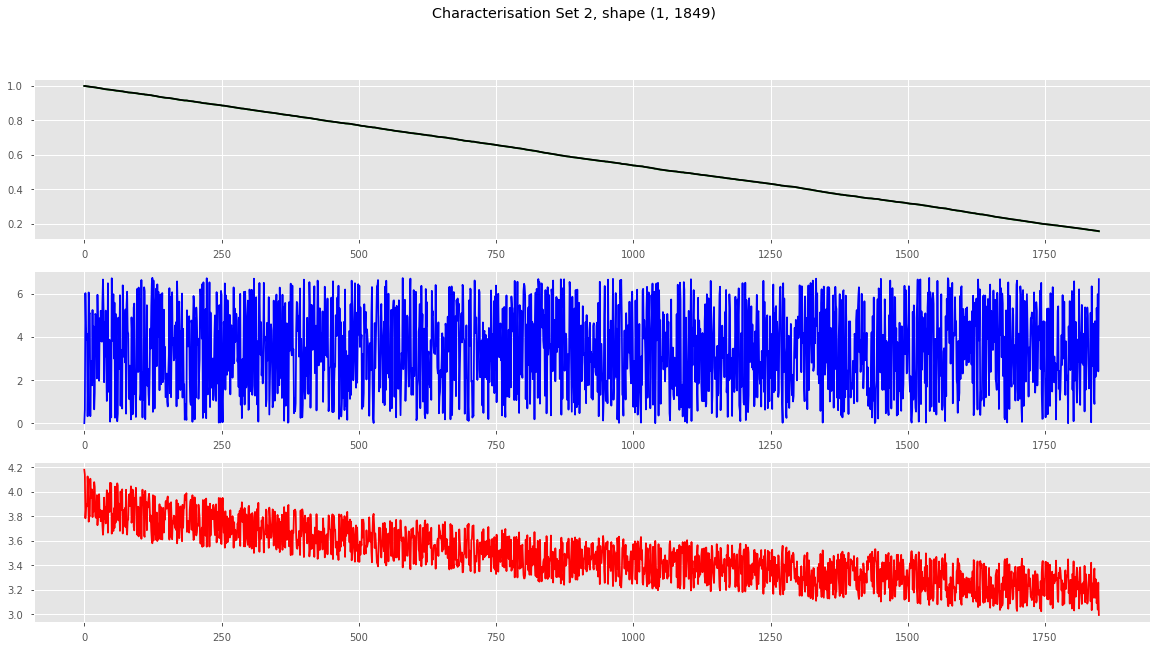

In [6]:
for i, set_dict in enumerate(Characterisation_Set['Sets']):
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.figure()
    plt.suptitle("Characterisation Set {}, shape {}".format(i, set_dict['SoC'].shape))
    plt.subplot(311)
    plt.plot(set_dict['SoC'].T, '-g')
    Characterisation_Set['Sets'][i]['SoC_prior'] = np.array(np.concatenate(([1.0], set_dict['SoC'][0, :-1]), axis=0), ndmin=2)
    plt.plot(Characterisation_Set['Sets'][i]['SoC_prior'].T, '-k')
    plt.subplot(312)
    plt.plot(set_dict['Current'].T, '-b')
    Characterisation_Set['Sets'][i]['Current_prior'] = np.array(np.concatenate(([set_dict['Current'][0, 0]], set_dict['Current'][0, :-1]), axis=0), ndmin=2)
    plt.subplot(313)
    plt.plot(set_dict['Voltage'].T, '-r')
    plt.show()

## 2. Train RNN from Prior

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN_Network(nn.Module):
    def __init__(self):
        super(RNN_Network, self).__init__()
        self.E_crit = nn.Linear(1, 1, bias=False)
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
    
    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))


    def forward(self, soc_prior, current_prior, current):
        
        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        V = self.VoC(soc) - I * Z

        # Predict SoC(t-1) -> SoC(t)
        soc = soc - I*V/self.E_crit.weight

        # Bounds
        max_test = soc[:, 0] > 1.0
        soc[max_test, 0] = 1.0
        min_test = soc[:, 0] < 0.0
        soc[min_test, 0] = 0.0000000001

        # Posterior Evidence
        if current.shape[1] == 1:
            I = torch.from_numpy(current).to(device, torch.float)
        else:
            I = torch.from_numpy(current.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # a Priori evidence
        V = self.VoC(soc) - I*Z

        return V, soc

In [8]:
save_network = "./Battery_Data/new_battery_cycles/Battery_RNN_Test_GT_new_v1.mdl"

In [9]:
rnn = RNN_Network()
# init
for W in rnn.parameters():
    if len(W.shape) > 1:
        if W.shape[0] == 1 and W.shape[1] ==  1:
            with torch.no_grad():
                W[0, 0] = Characterisation_Set['E_crit'] - 1000
        else:
            nn.init.normal_(W)
    else:
        nn.init.normal_(W)
    print(W)

Parameter containing:
tensor([[25267.1602]], requires_grad=True)
Parameter containing:
tensor([[ 0.3059, -0.7384],
        [-0.0604,  0.3814],
        [ 0.7947, -0.7078],
        ...,
        [-1.4698, -0.5286],
        [-0.0456, -0.9748],
        [-0.7320,  1.3814]], requires_grad=True)
Parameter containing:
tensor([ 0.0762, -1.3275,  1.4235,  ..., -0.2868,  1.4080, -1.9095],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1741,  1.4204, -0.8425,  ..., -0.3609,  1.0207, -0.8109],
        [ 0.3524, -0.6535,  1.1163,  ...,  1.8827,  0.9265,  0.8305],
        [ 0.6017,  0.4620,  1.0958,  ...,  0.0208, -0.6526,  0.3420],
        ...,
        [-0.6620, -0.4054,  1.1408,  ..., -2.0802, -2.3445, -0.9701],
        [ 0.5488, -0.5472,  0.2721,  ..., -0.2958,  1.1712,  2.0914],
        [ 1.3847, -2.4454, -0.2150,  ...,  0.6676,  0.9485,  0.6919]],
       requires_grad=True)
Parameter containing:
tensor([-0.5233,  0.6696,  1.8170, -0.7516,  0.6446,  1.0018, -0.1280, -0.2635,
        

In [10]:
rnn.to(device)

RNN_Network(
  (E_crit): Linear(in_features=1, out_features=1, bias=False)
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(rnn.parameters()) 

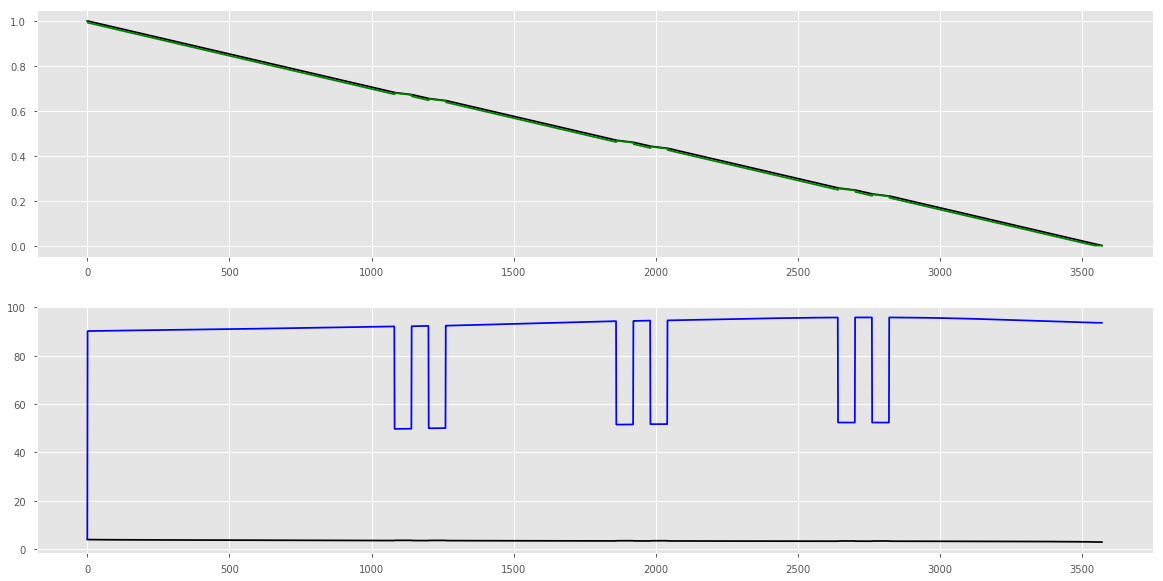

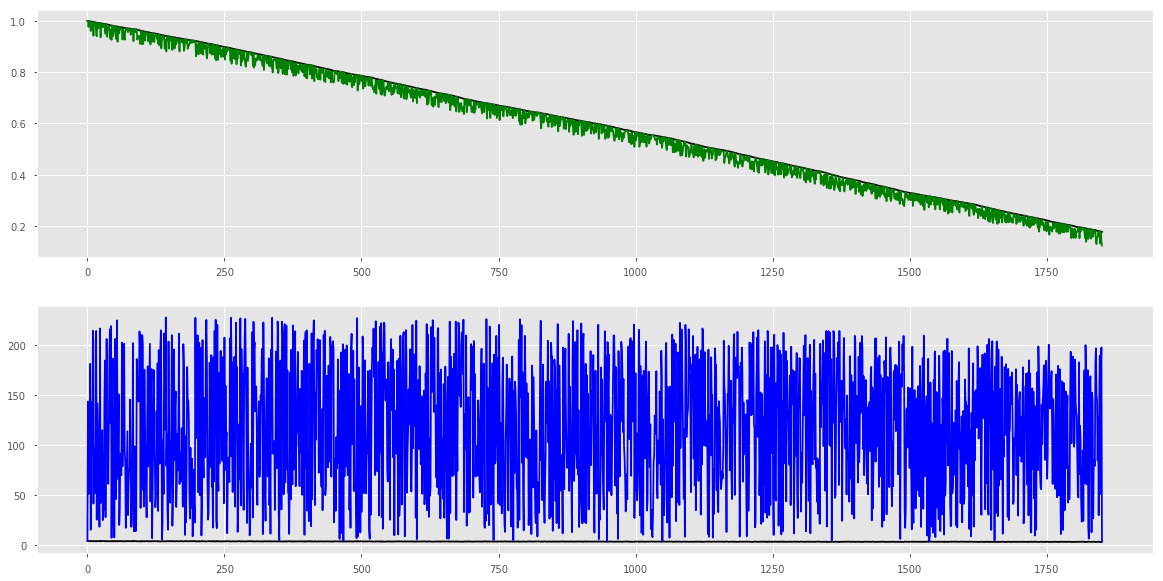

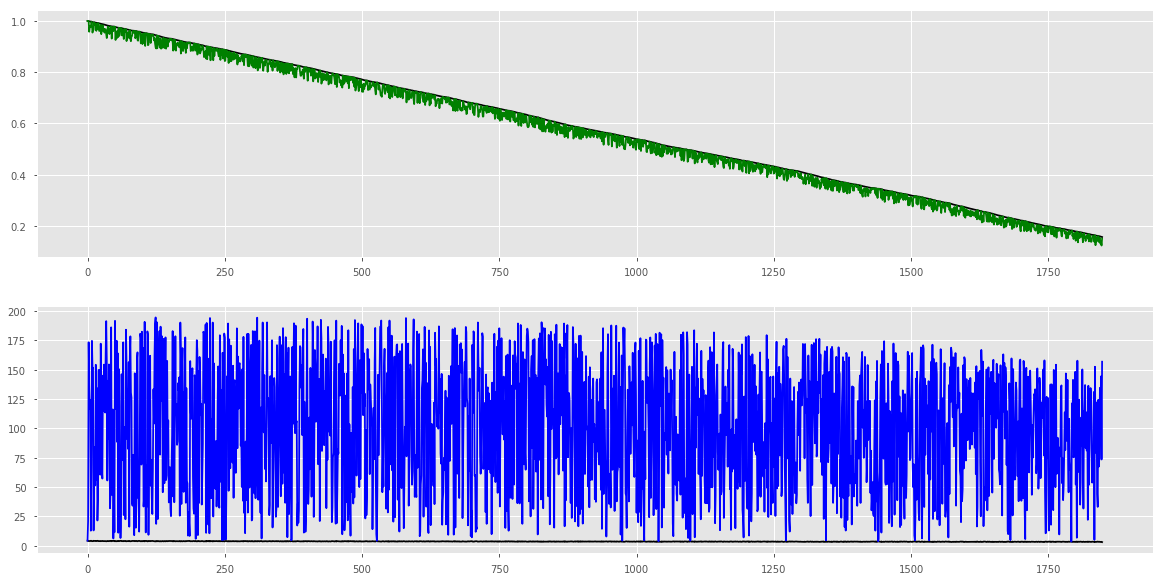

epoch 0, time since start: 0m 1s, estimated remaining time: 13h 58m 40s
New average minimum: 16565.573567708332Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 5640.25244140625Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 595.1800994873047Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 164.8778839111328Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 22.151814142862957Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 13.42378838857015Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 6.113707224527995Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 5.7178700764973955Ecrit 

New average minimum: 0.15953667213519415Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.15709247688452402Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.1547360196709633Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.15246381858984628Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.1502718577782313Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.14815821746985117Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.14612009252111116Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.1441536284983158Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0',

New average minimum: 0.08414727697769801Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08372962226470311Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0832608329753081Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08286264662941296Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08238513333102067Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08201431483030319Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08151901575426261Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.08118982737263043Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0

New average minimum: 0.057609387362996735Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05731925554573536Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.057035863089064755Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05674927309155464Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05646887763092915Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05618554415802161Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0559088367347916Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05562886502593756Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda

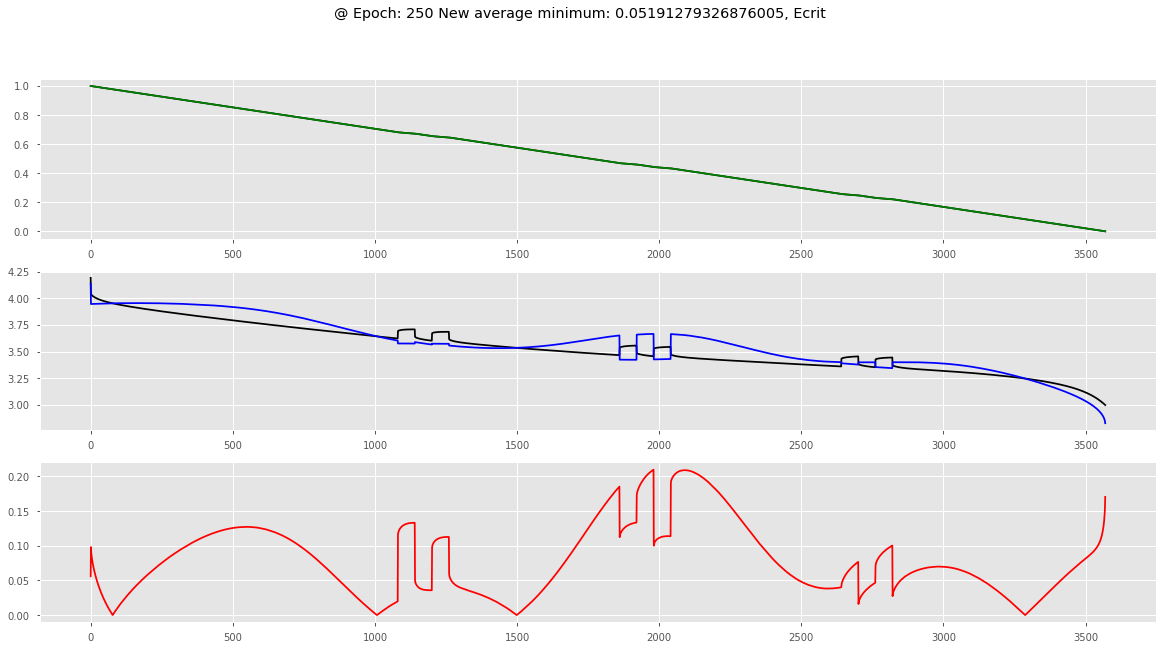

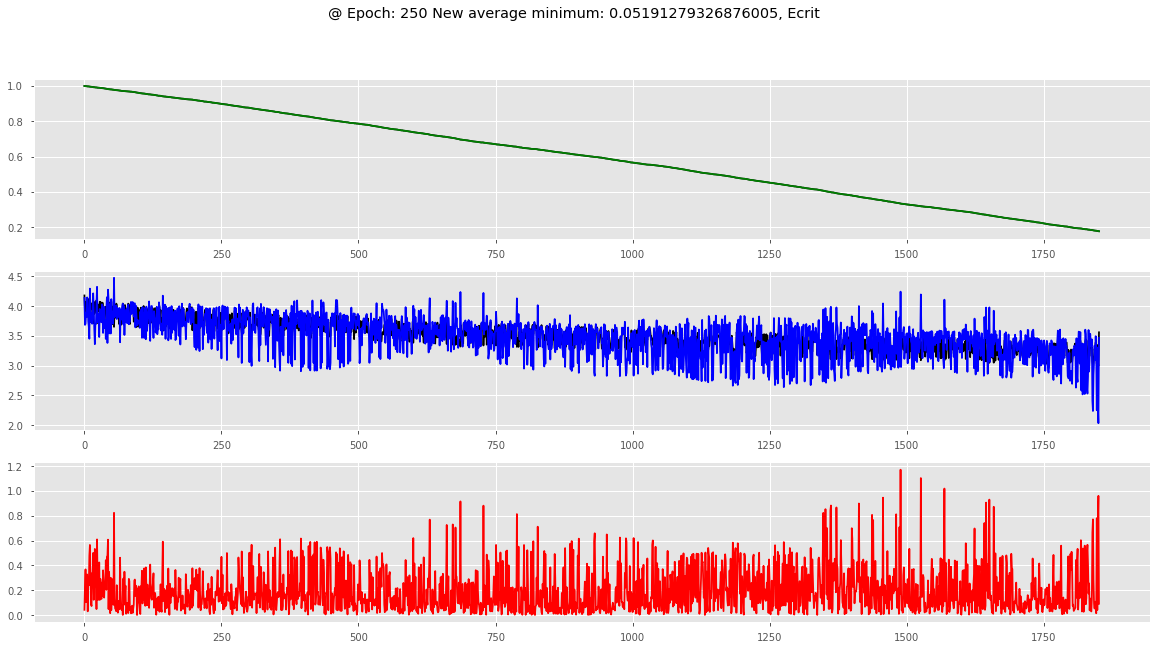

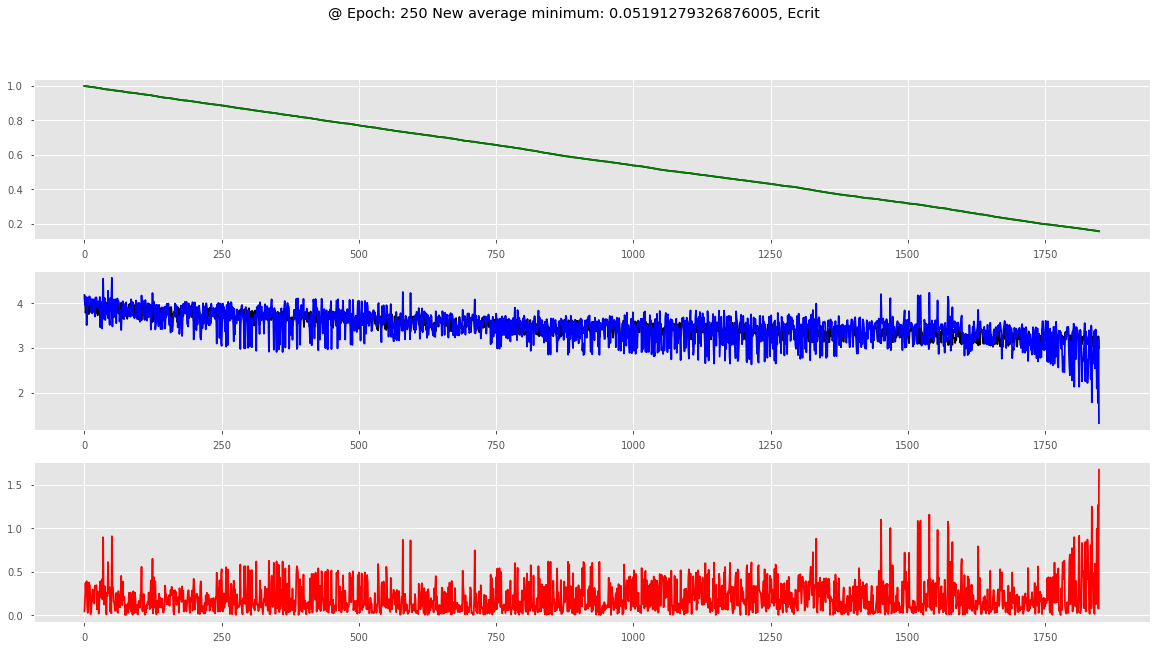

New average minimum: 0.05165977620830139Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.051407214254140854Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05115699271361033Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0509071641912063Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05066023704906305Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05041365356494983Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.05016946202764908Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.049925644571582474Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda

New average minimum: 0.0367756065291663Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.036607319954782724Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.03643991999949018Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.036273691492776074Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.03610828627521793Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.03594368292639653Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.035779972871144615Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.03561697108671069Ecrit Parameter containing:
tensor([[25267.1621]], device='cud

New average minimum: 0.026719192663828533Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.02660202483336131Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.026484929490834475Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.026368813899656136Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.026253041345626116Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.026137935773779947Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.026023344447215397Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.02590967807918787Ecrit Parameter containing:
tensor([[25267.1621]], device=

New average minimum: 0.01971520894827942Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01963745888012151Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01955970951045553Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.019483016105368733Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01940612541511655Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.019330453981334966Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01925431836086015Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.019179726640383404Ecrit Parameter containing:
tensor([[25267.1621]], device='cu

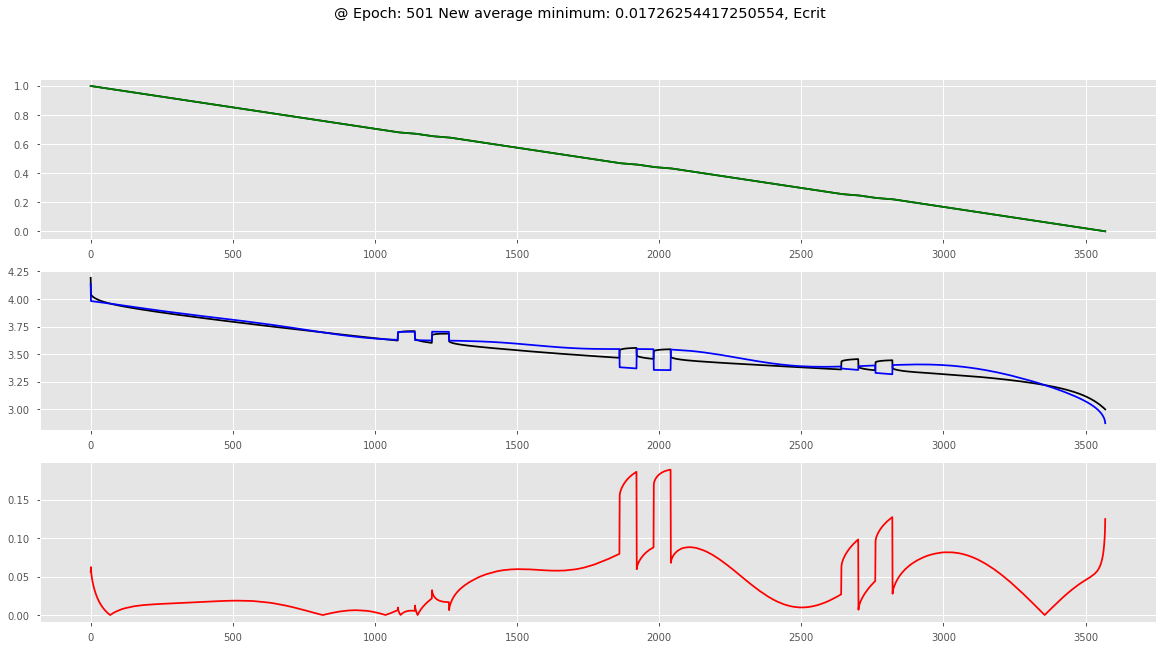

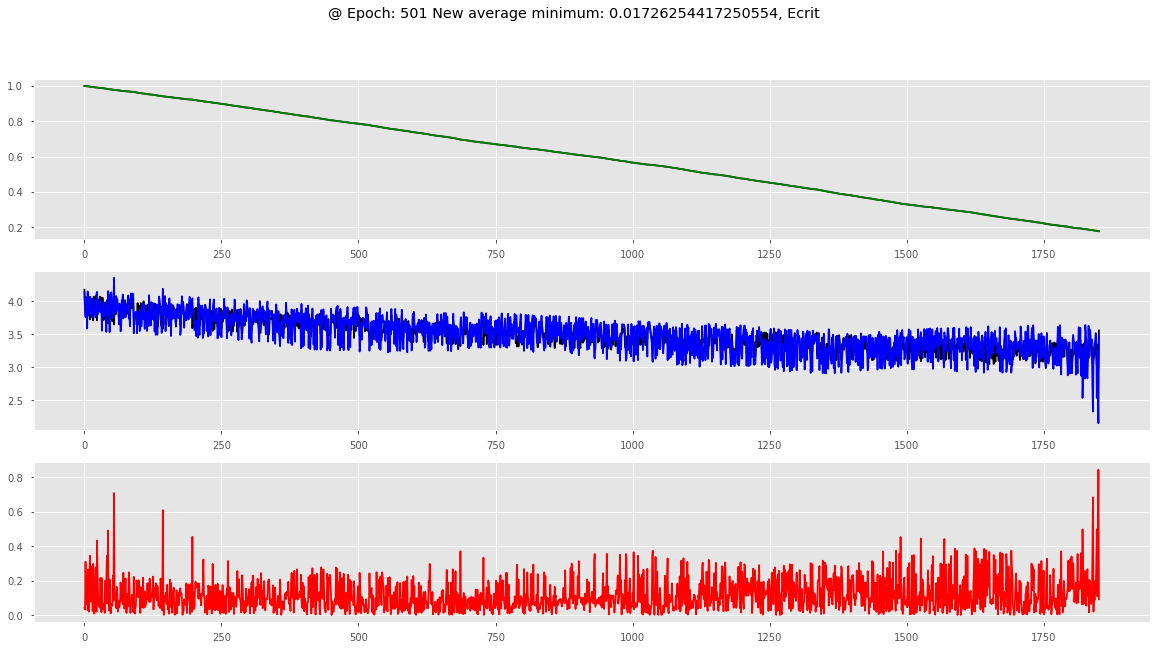

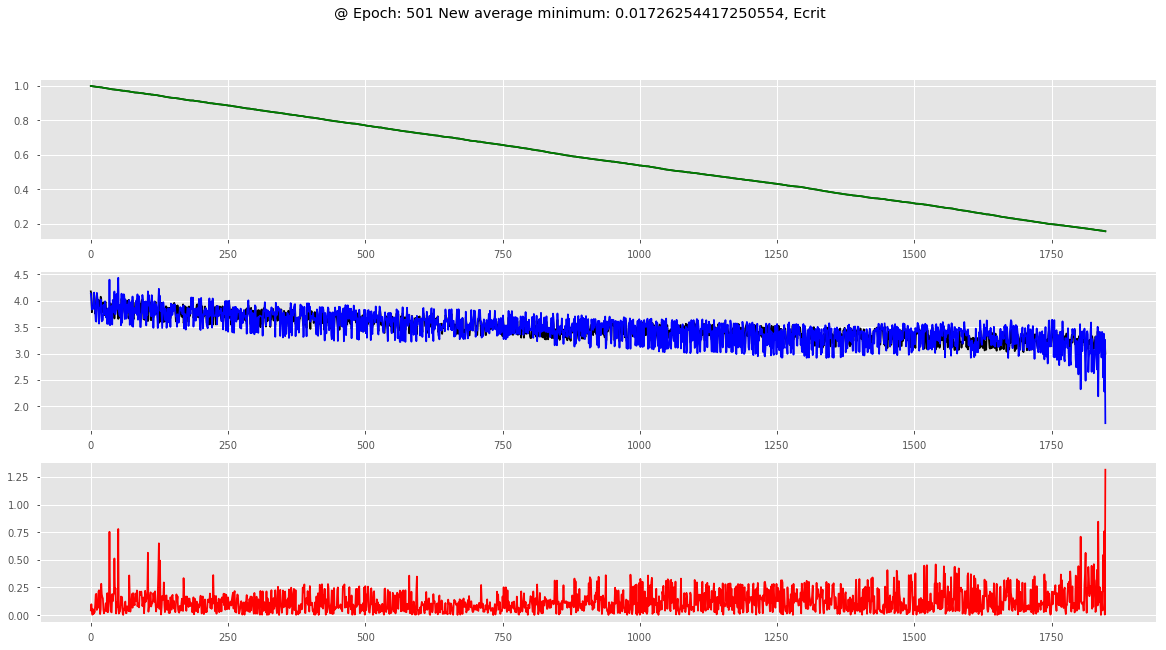

New average minimum: 0.017194961042453844Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01713925429309408Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.017070398200303316Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.017018090390289824Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.016946800984442234Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.016899412187437218Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.016824088680247467Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0167832737788558Ecrit Parameter containing:
tensor([[25267.1621]], device='

New average minimum: 0.012976092364018163Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.012898055060456196Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.012840054230764508Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.01282132564422985Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.012801884518315395Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0126805337301145Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.012552364574124416Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.012487009478112062Ecrit Parameter containing:
tensor([[25267.1621]], device='

New average minimum: 0.009824362195407351Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009784023820733031Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009752935341869792Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00972382522498568Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009708625342076024Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009693247421334187Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009668400899196664Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009660838870331645Ecrit Parameter containing:
tensor([[25267.1621]], device

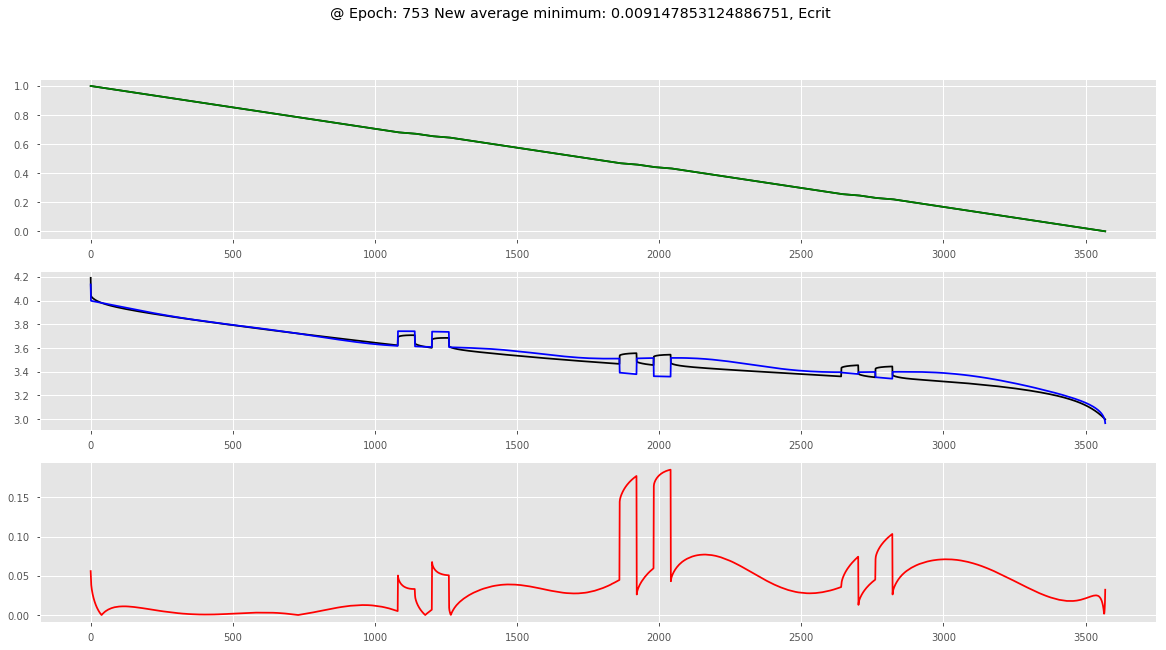

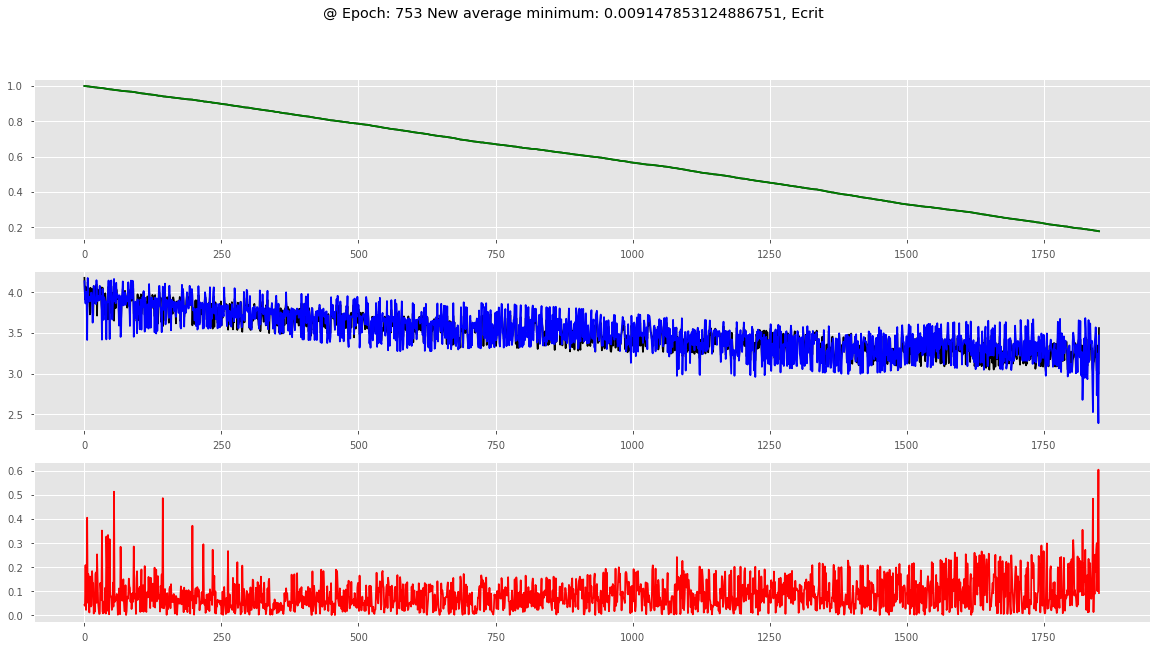

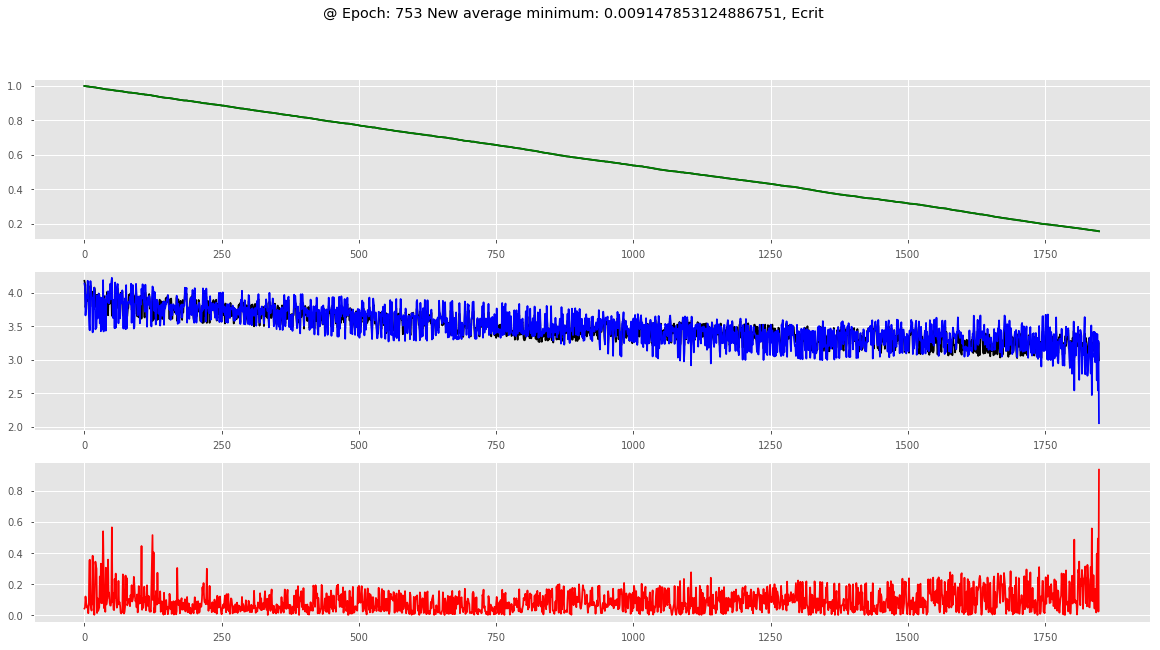

New average minimum: 0.009132368179659048Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009128306061029434Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0091123569291085Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009066824180384478Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.009003966658686599Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.008948837329323093Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00891268866447111Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.008888922088469068Ecrit Parameter containing:
tensor([[25267.1621]], device='

New average minimum: 0.007566421525552869Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.007556657462070386Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.007552533332879345Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.007533663224118452Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.007513331831432879Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.007494233859082063Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00747572653926909Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0074571497971192Ecrit Parameter containing:
tensor([[25267.1621]], device='

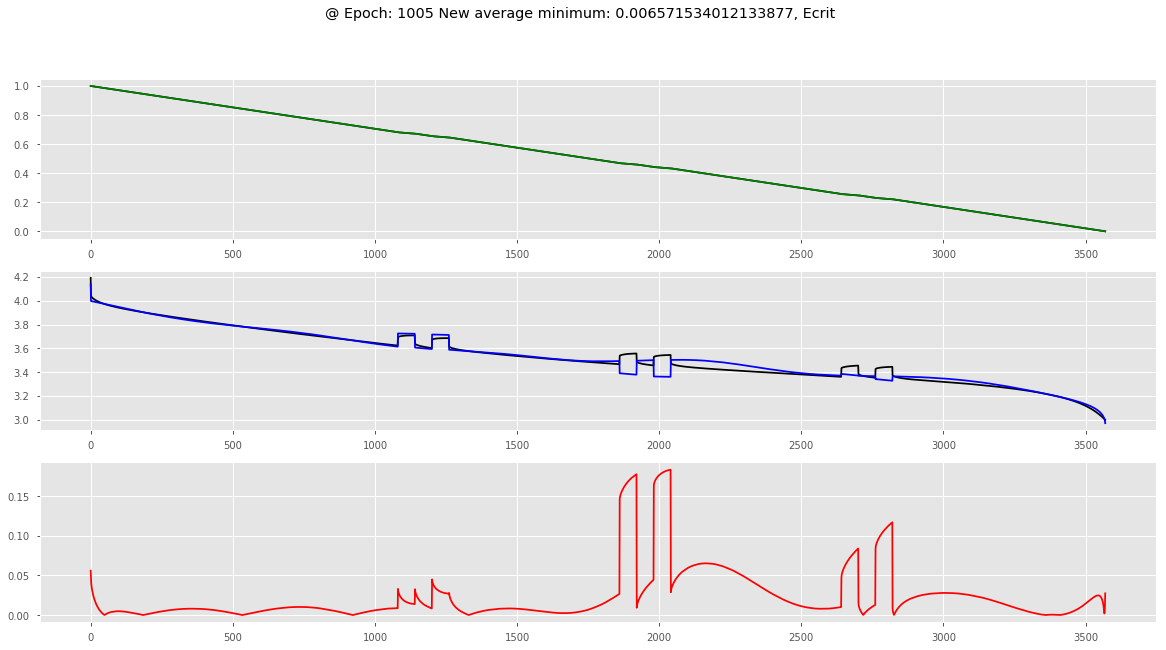

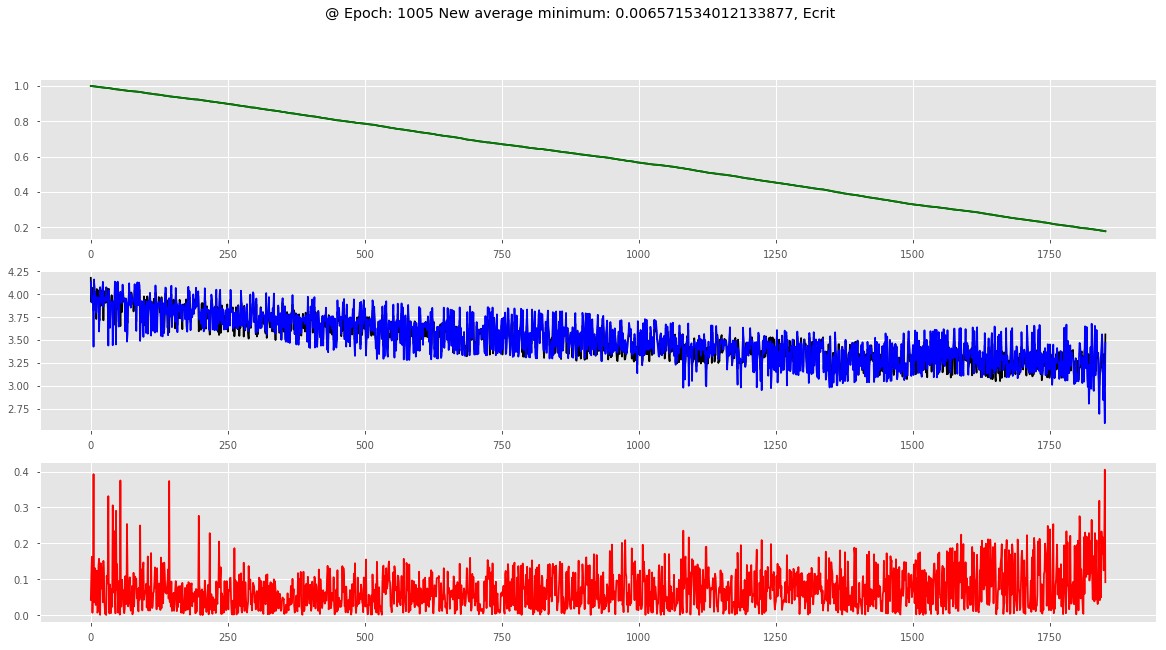

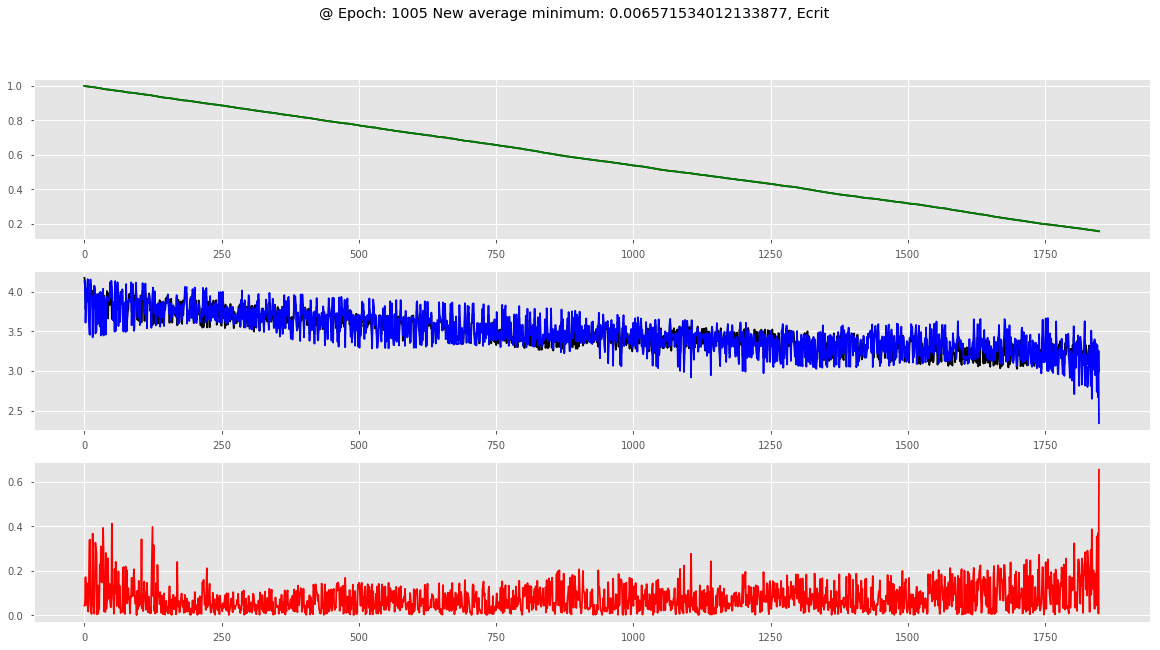

New average minimum: 0.0065706016806264715Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006560115104851623Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006552767163763444Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006548474193550646Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006537341551544766Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006535910457993547Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.006522866121182839Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00652272067964077Ecrit Parameter containing:
tensor([[25267.1621]], devic

New average minimum: 0.005905272167486449Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005893846546920638Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005881658095556001Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00586944492533803Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005857153562828898Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005844830069690943Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005832360863375167Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005820022934737305Ecrit Parameter containing:
tensor([[25267.1621]], device

New average minimum: 0.005276409598688285Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005274844899152716Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0052653296540180845Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005263532705915471Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005254345363937318Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005252304292904834Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005243326847751935Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005241083951356511Ecrit Parameter containing:
tensor([[25267.1621]], devi

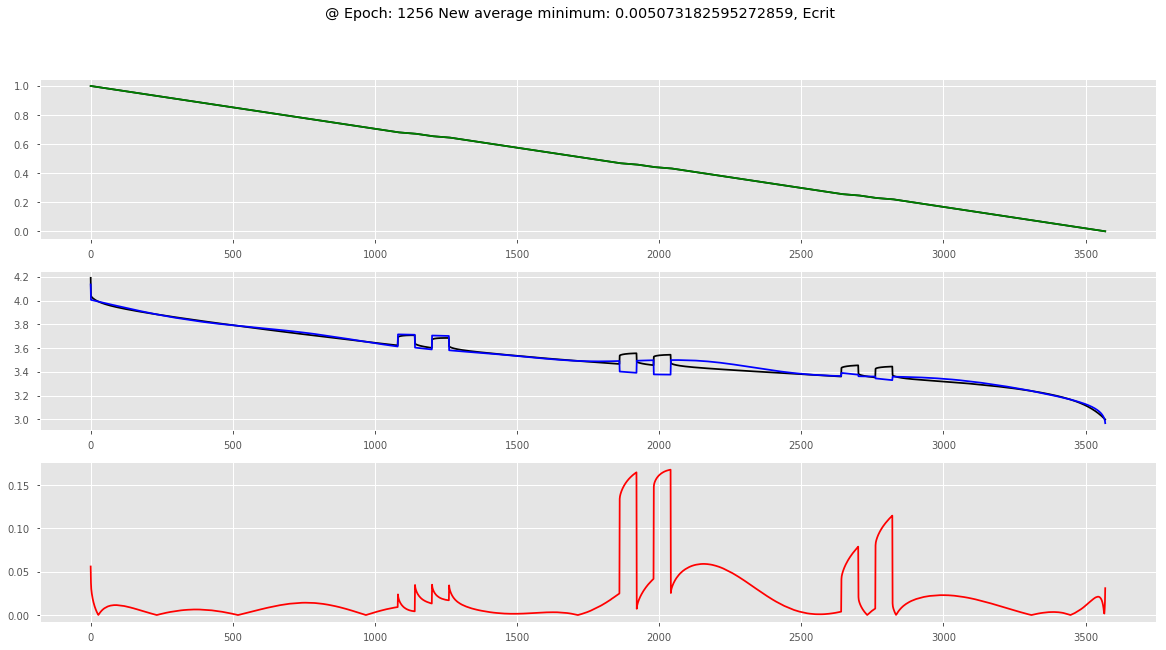

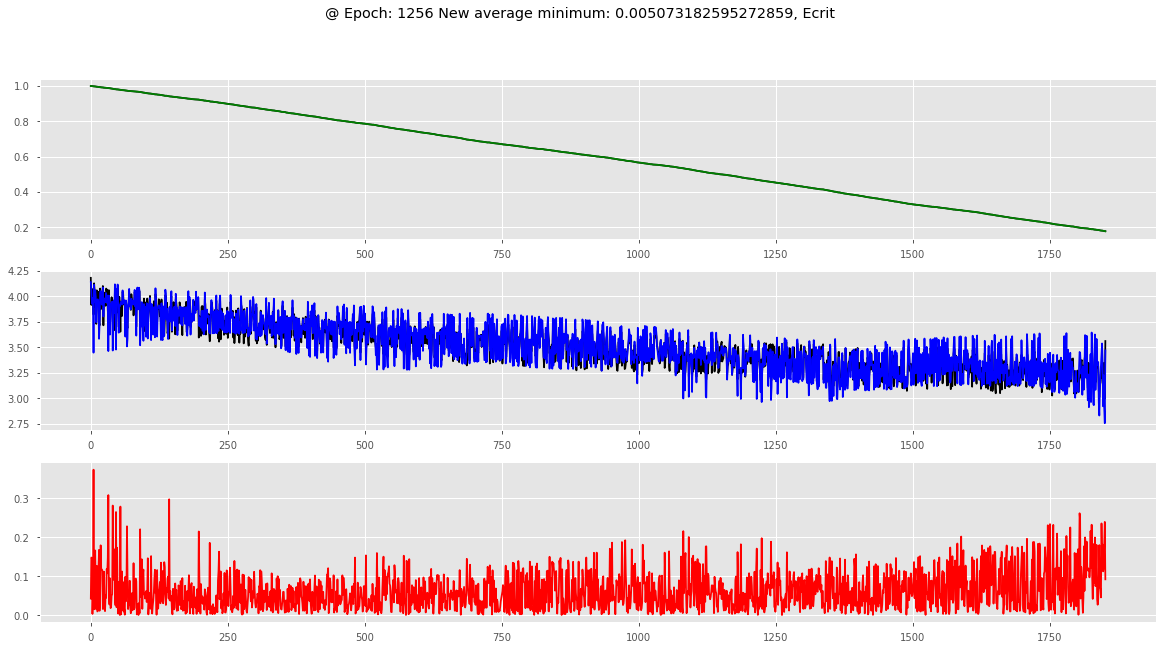

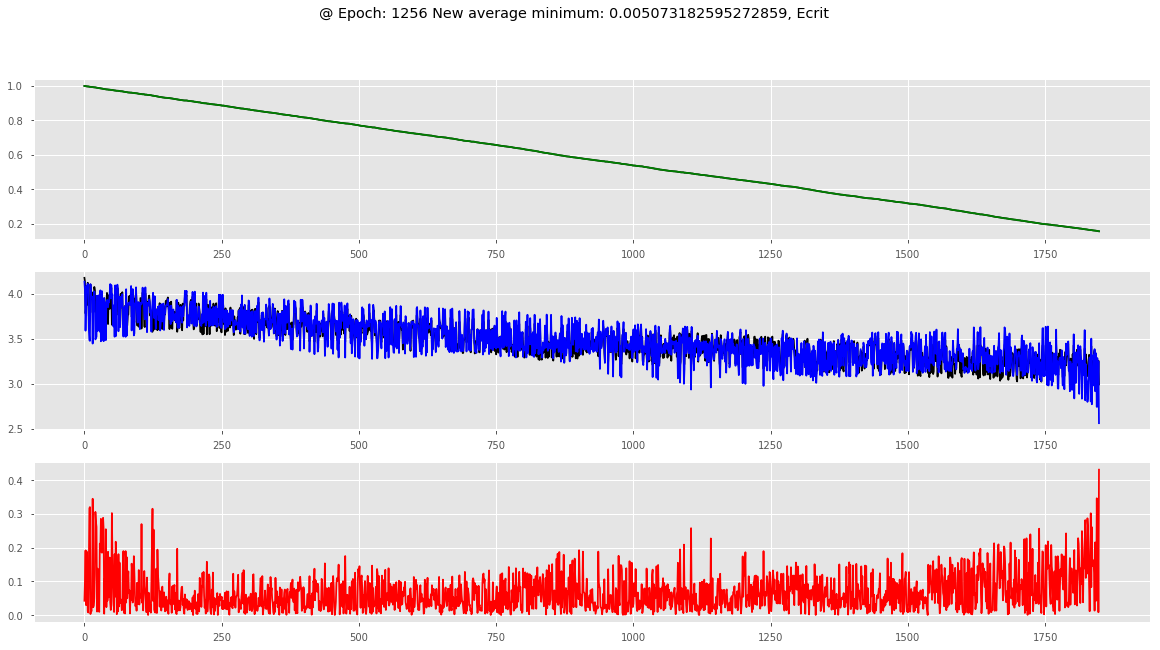

New average minimum: 0.005067353059227268Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005062109169860681Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005056411221933861Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005051112811391552Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005045341483006875Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005040051803613703Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005034418970656891Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.005029016562427084Ecrit Parameter containing:
tensor([[25267.1621]], devic

New average minimum: 0.004712061840109527Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004706809995695949Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.00470169404676805Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004696457530371845Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0046914008756478625Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004685968315849702Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0046811843834196525Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004675776232033968Ecrit Parameter containing:
tensor([[25267.1621]], devi

New average minimum: 0.004383681147980194Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004379611772795518Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004374425858259201Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004370357375591993Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004365608173732956Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004360852957082291Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0043569333696117Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004351613034183781Ecrit Parameter containing:
tensor([[25267.1621]], device=

New average minimum: 0.004007212817668915Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.004001040710136294Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003998618922196329Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0039941854774951935Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003988925949670374Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003987563890404999Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003980631590820849Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003978435221749048Ecrit Parameter containing:
tensor([[25267.1621]], devi

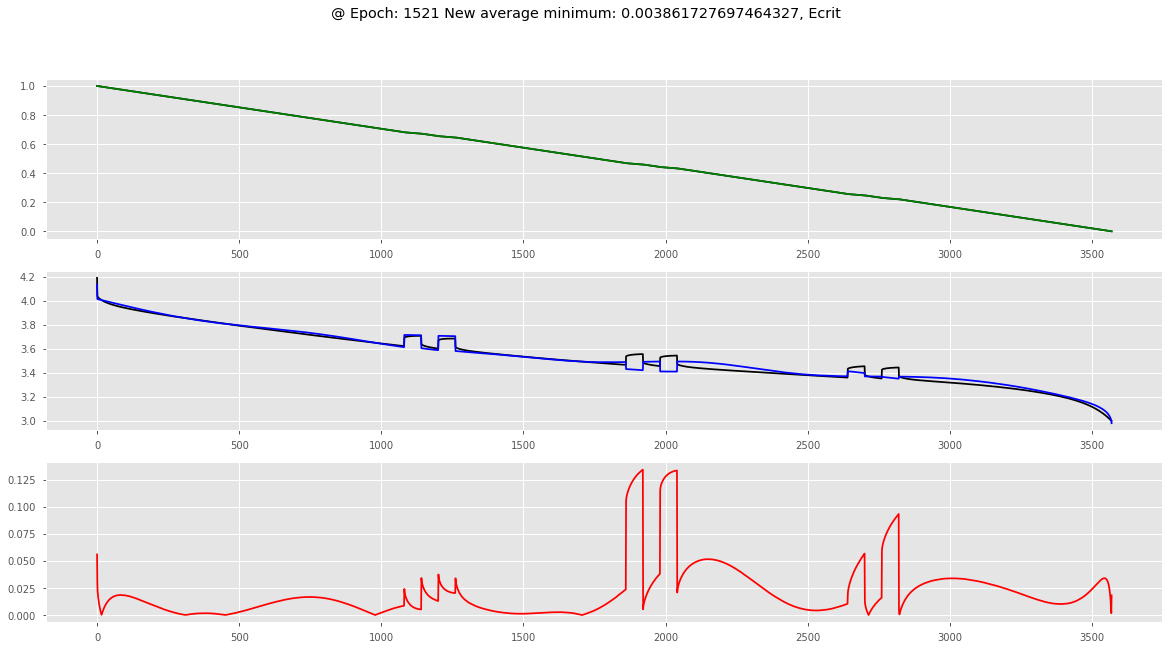

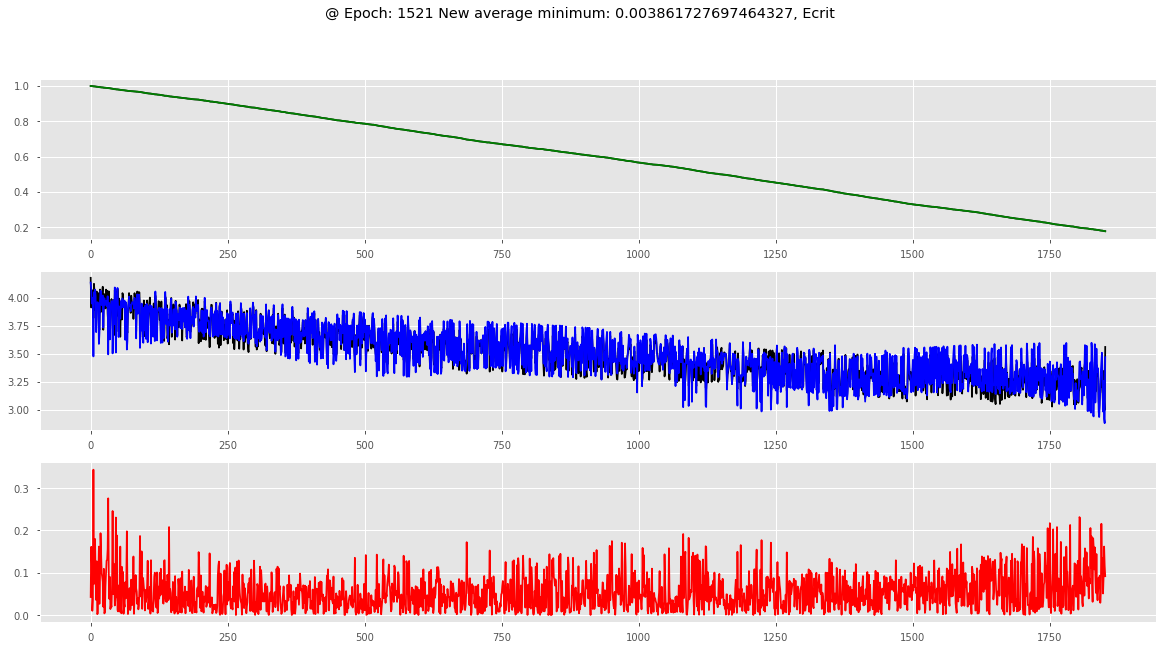

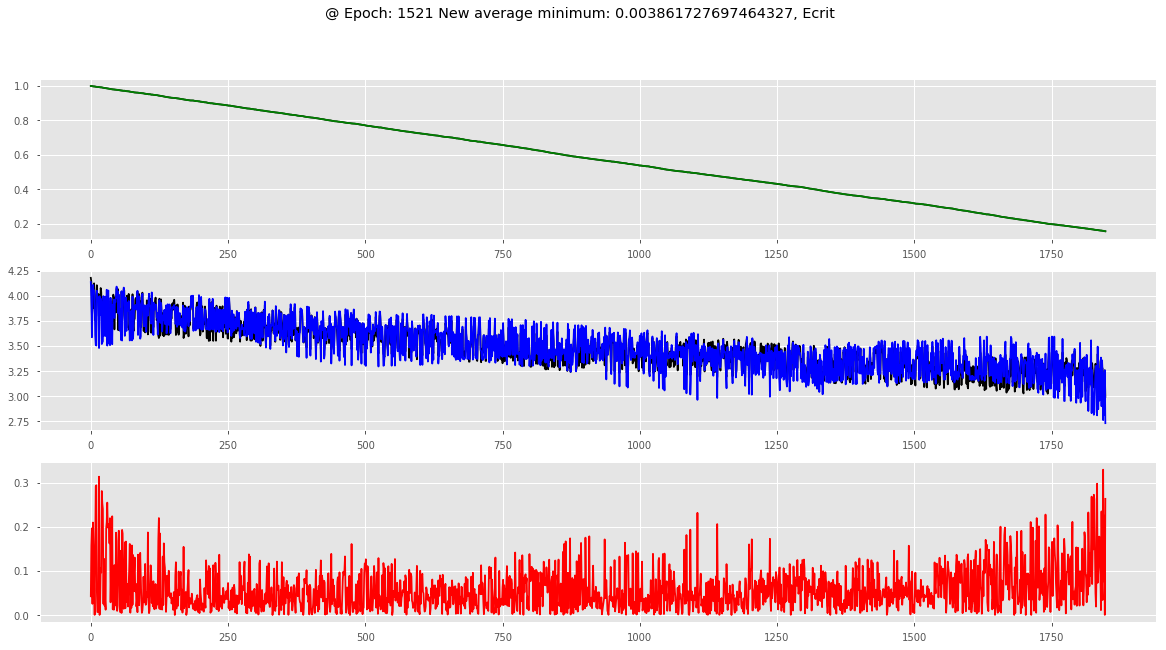

New average minimum: 0.0038474057413016758Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003816272558954855Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0038150984716291227Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0038106731371954083Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0038044494576752186Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0038037324557080865Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003795356994184355Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0037882537192975483Ecrit Parameter containing:
tensor([[25267.1621]],

New average minimum: 0.0033097005992506943Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0033080178351762393Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003298423641050855Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0032956054977451763Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003287027997430414Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0032842733586827912Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.0032758183466891446Ecrit Parameter containing:
tensor([[25267.1621]], device='cuda:0', requires_grad=True)
New average minimum: 0.003273369298161318Ecrit Parameter containing:
tensor([[25267.1621]], 

KeyboardInterrupt: 

In [12]:
import time
import math

epochs = 50000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
rnn.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

count_since_plot = 0
for epoch in range(epochs):
    count = -1
    avg_loss = 0
    loss_set_hist = []
    
    for set_dict in Characterisation_Set['Sets']:
        count += 1
        V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
        optimizer.zero_grad()
        soc_prior = set_dict['SoC_prior'].T
        current_prior = set_dict['Current_prior'].T
        current =  set_dict['Current'].T
        V_est, SoC = rnn(soc_prior, current_prior, current)
        loss = criterion(V_est, V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        loss_set_hist.append(loss.item())
        if epoch == 0:
            with torch.no_grad():
                V_est, SoC = rnn(soc_prior, current_prior, current)
                plt.figure(count)
                plt.subplot(2,1,1)
                plt.plot(set_dict['SoC'].T, 'k')
                plt.plot(SoC.to("cpu").numpy(), 'g')
                plt.subplot(2,1,2)
                plt.plot(V.to("cpu").numpy(), 'k')
                plt.plot(V_est.to("cpu").numpy(), 'b')
                plt.show()
    loss_hist.append(loss_set_hist)
    avg_loss /= (count+1)
    count_since_plot += 1
    if epoch % 1000 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        torch.save(rnn.state_dict(), save_network)
        loss_min = avg_loss
        if count_since_plot > 250: 
            count_since_plot = 0
            with torch.no_grad():
                for set_dict in Characterisation_Set['Sets']:
                    V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
                    soc_prior = set_dict['SoC_prior'].T
                    current_prior = set_dict['Current_prior'].T
                    current =  set_dict['Current'].T
                    V_est, SoC = rnn(soc_prior, current_prior, current)
                    plt.figure(count)
                    plt.suptitle("@ Epoch: {} New average minimum: {}, Ecrit".format(epoch, avg_loss, rnn.E_crit.weight))
                    plt.subplot(3,1,1)
                    plt.plot(set_dict['SoC'].T, 'k')
                    plt.plot(SoC.to("cpu").numpy(), 'g')
                    plt.subplot(3,1,2)
                    plt.plot(V.to("cpu").numpy(), 'k')
                    plt.plot(V_est.to("cpu").numpy(), 'b')
                    plt.subplot(3,1,3)
                    plt.plot(np.abs(V.to("cpu").numpy() - V_est.to("cpu").numpy()), 'r')
                    plt.show()
        else:
            print("New average minimum: " + str(avg_loss) + "Ecrit " + str(rnn.E_crit.weight))

In [ ]:
accumulate_soc_error = []
accumate_v_error = []
with torch.no_grad():
    for set_dict in Characterisation_Set['Sets']:
        V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
        soc_prior = set_dict['SoC_prior'].T
        current_prior = set_dict['Current_prior'].T
        current =  set_dict['Current'].T
        V_est, SoC = rnn(soc_prior, current_prior, current)
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(set_dict['SoC'].T, 'k')
        plt.plot(SoC.to("cpu").numpy(), 'g')
        plt.subplot(2,1,2)
        error = set_dict['SoC'].T - SoC.to("cpu").numpy()
        accumulate_soc_error.append(error)
        soc_mean_error = np.mean(error)
        soc_std_error = np.std(error)
        plt.title("N({}, {})".format(soc_mean_error, soc_std_error))
        plt.plot(np.abs(set_dict['SoC'].T - SoC.to("cpu").numpy()), 'r')
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(V.to("cpu").numpy(), 'k')
        plt.plot(V_est.to("cpu").numpy(), 'b')
        plt.subplot(2,1,2)
        error = V.to("cpu").numpy() - V_est.to("cpu").numpy()
        accumate_v_error.append(error)
        voltage_mean_error = np.mean(error)
        voltage_std_error = np.std(error)
        plt.title("N({}, {})".format(voltage_mean_error, voltage_std_error))
        plt.plot(np.abs(V.to("cpu").numpy() - V_est.to("cpu").numpy()), 'r')
plt.show()
soc_error = np.concatenate(accumulate_soc_error)
soc_mean = np.mean(soc_error)
print("SoC mean:", soc_mean)
soc_std = np.std(soc_error)
print("SoC std:", soc_std)
v_error = np.concatenate(accumate_v_error)
v_mean = np.mean(v_error)
print("Voltage mean:", v_mean)
v_std = np.std(v_error)
print("Voltage std:", v_std)

In [ ]:
class Polarising_Impedance_Map(nn.Module):
    def __init__(self):
        super(Polarising_Impedance_Map, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)

    def forward(self, soc_prior, current_prior):
        
        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        return Z

In [ ]:
Z_pol = Polarising_Impedance_Map()
Z_pol.load_state_dict(torch.load(save_network))
Z_pol.to(device)

In [ ]:
soc_map = np.array(np.linspace(0, 1.0, 1000), ndmin=2)
Z_map = []
plt.figure()
for i in range(1, 16):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*float(i/2.0))
        Z_map.append(Z.cpu().numpy())
#         plt.subplot(2, 1, 1)
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i/2.0))
#         plt.subplot(2, 1, 2)
#         plt.semilogy(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i))
# plt.axis([-0.1, 1.1, 0.0, 0.1])
plt.legend()
plt.show()

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = soc_map
Y = np.linspace(0.1, 7.5, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T
print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()